<a href="https://colab.research.google.com/github/SalhaAlzahrani/SkinLiTE/blob/main/_Skin_SupConLearn_ISIC2019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🟪 ISIC 2019 Skin Lesion images for classification with Supervised Contrastive Learning



## Introduction

Supervised Contrastive Learning (Prannay Khosla et al.) is a training methodology that outperforms supervised training with crossentropy on classification tasks.


Essentially, training an image classification model with Supervised Contrastive Learning is performed in two phases:

- Training an encoder to learn to produce vector representations of input images such that representations of images in the same class will be more similar compared to representations of images in different classes.
- Training a classifier on top of the frozen encoder.

In [ ]:
!pip install -U -q tensorflow-addons
!pip install nest_asyncio
!pip install keras-cv

In [ ]:
from keras.src.applications import imagenet_utils

import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_addons as tfa
from keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import pathlib
import glob
import keras_cv
import os
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import class_weight

from google.colab import drive
# Define the path to the MRI data directory
drive.mount('/content/drive', force_remount=True)

import nest_asyncio

Mounted at /content/drive


# 🟣 Plot functions

In [ ]:
def plot_training_curves(history, title):
    loss = np.array(history.history['loss'])
    val_loss = np.array(history.history['val_loss'])
    epochs = range(len(history.history['loss']))
    accuracy = np.array(history.history['accuracy'])
    val_accuracy = np.array(history.history['val_accuracy'])

    plt.style.use('seaborn') #ggplot #bmh
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 2.5))
    fig.patch.set_facecolor('xkcd:white')

    # Plot loss
    ax1.plot(epochs, loss, label='training_loss', marker='.', )
    ax1.plot(epochs, val_loss, label='val_loss', marker='.', )
    ax1.fill_between(epochs, loss, val_loss, where=(loss > val_loss), color='C0', alpha=0.3, interpolate=True)
    ax1.fill_between(epochs, loss, val_loss, where=(loss < val_loss), color='C1', alpha=0.3, interpolate=True)
    ax1.set_title('Loss: '+title, fontsize=10)
    ax1.set_xlabel('Epochs', fontsize=10)
    ax1.legend(fontsize=8)

    # Plot accuracy
    ax2.set_ylim(ymin=0, ymax=1.1)
    ax2.plot(epochs, accuracy, label='training_accuracy', marker='.')
    ax2.plot(epochs, val_accuracy, label='val_accuracy', marker='.')
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy > val_accuracy), color='C0', alpha=0.3, interpolate=True)
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy < val_accuracy), color='C1', alpha=0.3, interpolate=True)
    ax2.set_title('Accuracy: '+title, fontsize=10)
    ax2.set_xlabel('Epochs', fontsize=10)
    ax2.legend(fontsize=10)

In [ ]:
def visualize_dataset(dataset, title):
  plt.figure(figsize=(10, 10)).suptitle(title, fontsize=18)
  for images, labels in iter(dataset.take(9)):
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      img = tf.image.rgb_to_grayscale(images[i])
      plt.imshow(img, cmap='gist_gray')
      ax.grid()
      plt.axis("off")

# 🟣 Hyperparameters


In [ ]:
IMG_SIZE = 256 # We'll resize input images to this size.
input_shape = (256, 256, 3)
learning_rate = 0.001
weight_decay = 0.0001
num_epochs = 100

batch_size = 265
hidden_units = 512
projection_units = 128
dropout_rate = 0.5
temperature = 0.05

# 🟣 Dataset

In [ ]:
path = '/content/drive/MyDrive/_MyResearch_/Skin_Disease_Datasets/ISIC 2019 Skin Lesion images for classification/'
# train data
train_ds = image_dataset_from_directory(
    directory= path ,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(IMG_SIZE,IMG_SIZE),
    color_mode='rgb',
    shuffle=True,
    seed=1000,
    validation_split=0.2,
    subset='training',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)
# validation data
val_ds = image_dataset_from_directory(
    directory=path ,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(IMG_SIZE,IMG_SIZE),
    color_mode='rgb',
    shuffle=True,
    seed=1000,
    validation_split=0.2,
    subset='validation',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)
#Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

Found 25331 files belonging to 8 classes.
Using 20265 files for training.
Found 25331 files belonging to 8 classes.
Using 5066 files for validation.


In [ ]:
train_ds_ = image_dataset_from_directory(
    directory= path ,
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(IMG_SIZE,IMG_SIZE),
)
class_names = train_ds_.class_names
print(class_names)
##################
NUM_CLASSES = len(class_names)
##################
num_images_per_class = []
for label in class_names:
    dir_name = path + label
    num_images_per_class.append(len([name for name in os.listdir(dir_name)]))
# y_train=list of train labels wrt to given directory format
y_train=[]
for i in range(0, len(num_images_per_class)):
    y_train+=[i]*num_images_per_class[i]
classes = list()
for i in range(NUM_CLASSES): classes.append(i)
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=np.asarray(y_train))
class_weights_dict = {}
for i in range(len(class_weights)):
   class_weights_dict[i] = class_weights[i]
class_weights_dict

Found 25331 files belonging to 8 classes.
['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC']


{0: 3.652104959630911,
 1: 0.9528663857959675,
 2: 1.2066977896341464,
 3: 13.248430962343097,
 4: 0.7002156125608138,
 5: 0.24593203883495146,
 6: 5.041998407643312,
 7: 12.515316205533598}

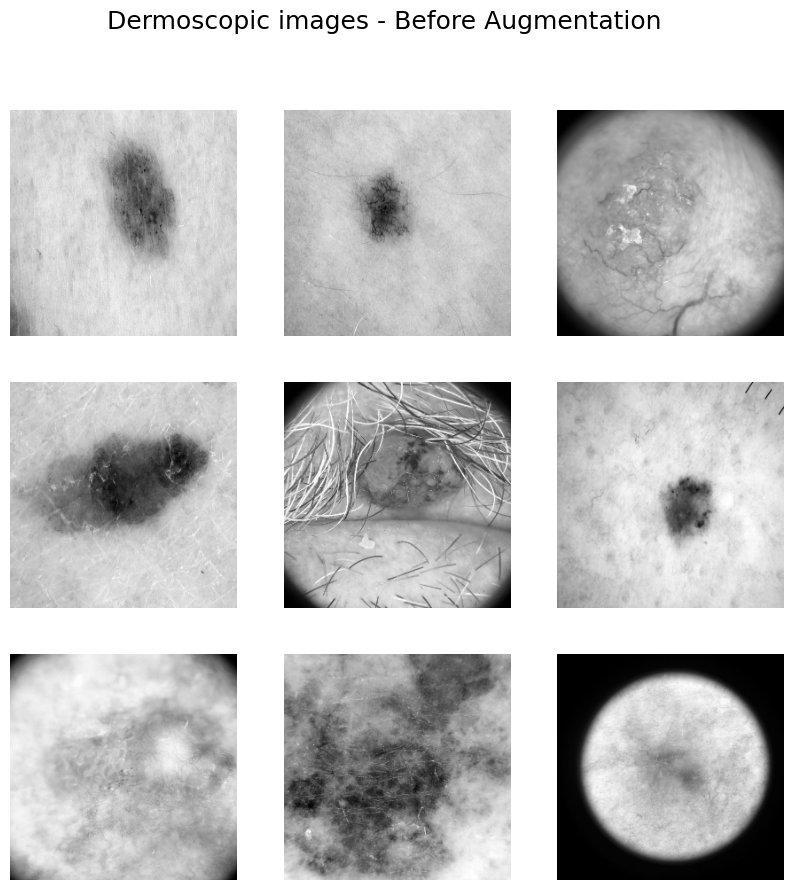

In [ ]:
visualize_dataset(train_ds, title="Dermoscopic images - Before Augmentation")

# 🅰 Data augmentation



In [ ]:
def to_dict(image, label):
    image = tf.cast(image, tf.float32)
    label = tf.one_hot(label, NUM_CLASSES)
    return {"images": image, "labels": label}

def preprocess_for_model(inputs):
    images, labels = inputs["images"], inputs["labels"]
    images = tf.cast(images, tf.float32)
    return images, labels

randaug = keras_cv.layers.RandAugment(value_range=(0, 255), augmentations_per_image=3, magnitude=0.5)
augmix = keras_cv.layers.AugMix([0, 255])
mixup = keras_cv.layers.MixUp()
cutmix = keras_cv.layers.CutMix()

#No augmentation
train_ds_v = train_ds.map(to_dict)
train_ds_v = train_ds_v.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
train_ds_v = train_ds_v.prefetch(AUTOTUNE)
val_ds_v = val_ds.map(to_dict)
val_ds_v = val_ds_v.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
val_ds_v = val_ds_v.prefetch(AUTOTUNE) #Use this for fit

def aug_pipeline1(samples):
    samples = randaug(samples, training=True)
    return samples
def aug_pipeline2(samples):
    samples = augmix(samples, training=True)
    return samples
def aug_pipeline3(samples):
    samples = mixup(samples, training=True)
    return samples
def aug_pipeline4(samples):
    samples = cutmix(samples, training=True)
    return samples
#RandAug
randaug_ds = train_ds.shuffle(1000).map(to_dict)
randaug_ds = randaug_ds.map(aug_pipeline1)
randaug_ds = randaug_ds.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
randaug_ds = randaug_ds.prefetch(AUTOTUNE) #Use this for fit

#AugMix
augmix_ds = train_ds.shuffle(1000).map(to_dict)
augmix_ds = augmix_ds.map(aug_pipeline2)
augmix_ds = augmix_ds.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
augmix_ds = augmix_ds.prefetch(AUTOTUNE) #Use this for fit

#MixUp
mixup_ds = train_ds.shuffle(1000).map(to_dict)
mixup_ds = mixup_ds.map(aug_pipeline3)
mixup_ds = mixup_ds.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
mixup_ds = mixup_ds.prefetch(AUTOTUNE) #Use this for fit

#CutMix
cutmix_ds = train_ds.shuffle(1000).map(to_dict)
cutmix_ds = cutmix_ds.map(aug_pipeline4)
cutmix_ds = cutmix_ds.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
cutmix_ds = cutmix_ds.prefetch(AUTOTUNE) #Use this for fit

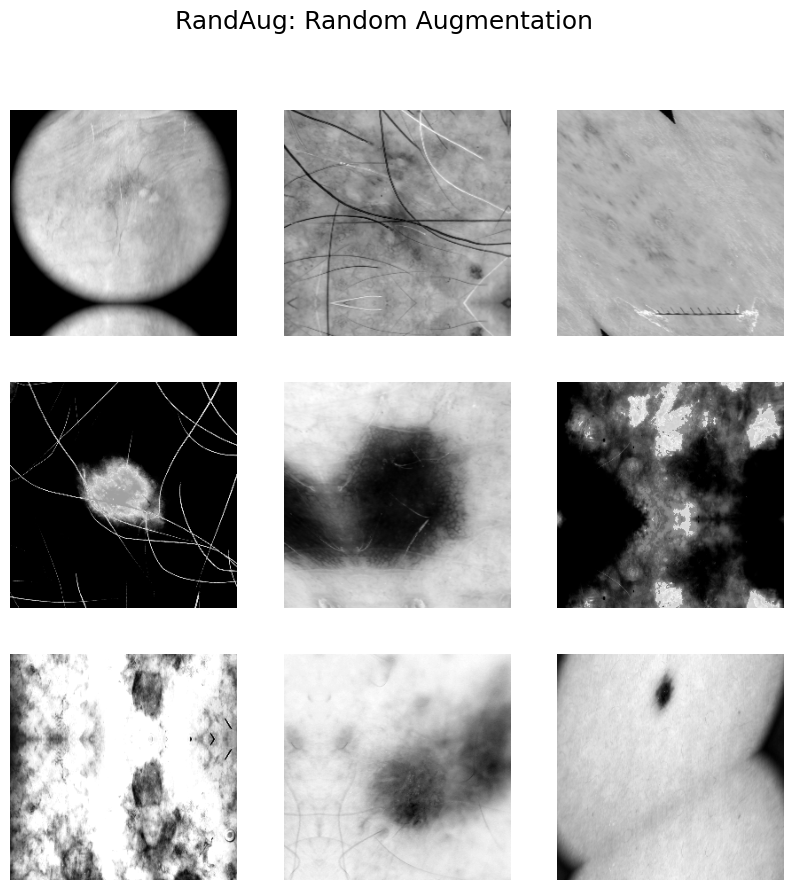

In [ ]:
visualize_dataset(randaug_ds, title="RandAug: Random Augmentation")

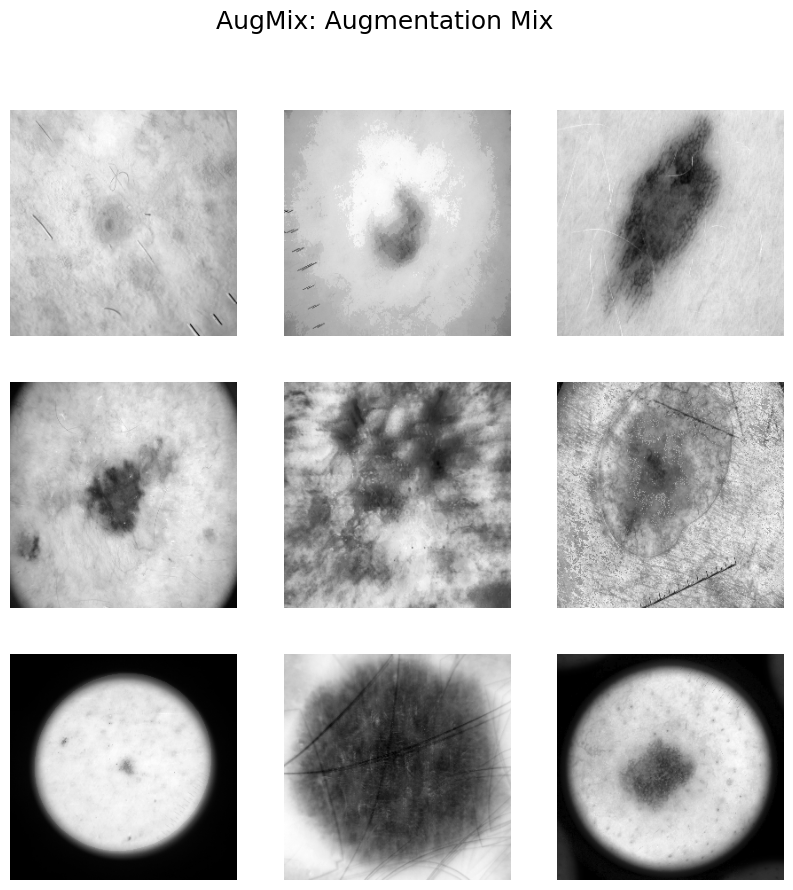

In [ ]:
visualize_dataset(augmix_ds, title="AugMix: Augmentation Mix")

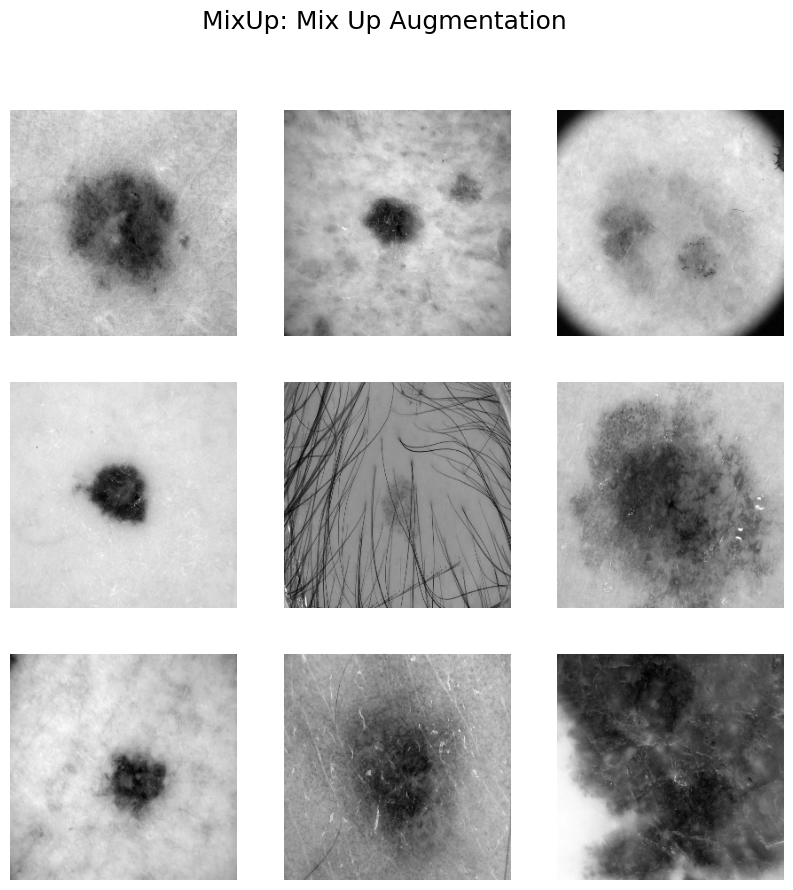

In [ ]:
visualize_dataset(mixup_ds, title="MixUp: Mix Up Augmentation")

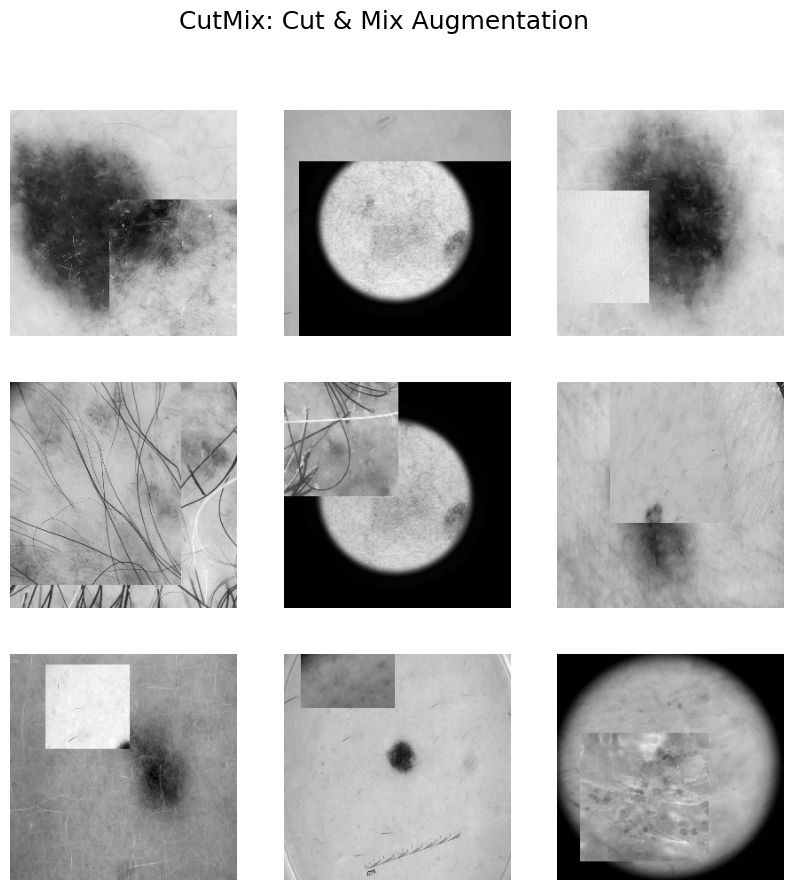

In [ ]:
visualize_dataset(cutmix_ds, title="CutMix: Cut & Mix Augmentation")

# 🟣 Experiment


In [ ]:
def run_experiment(training_dataset, validation_dataset, model):
    # Create Adam optimizer with weight decay.
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay,
    )
    # Compile the model.
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
            keras.metrics.AUC(name='AUC'),
            keras.metrics.Precision(name='Precision'),
            keras.metrics.Recall(name='Recall'),
            keras.metrics.F1Score(name='F1 score'),
        ],
    )
    # Create a learning rate scheduler callback.
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=5
    )
    # Create an early stopping callback.
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        training_dataset,
        validation_data = validation_dataset,
        batch_size=batch_size,
        epochs=num_epochs,
        class_weight=class_weights_dict,
        callbacks=[early_stopping, reduce_lr],
    )
    # Return history to plot learning curves.
    return history

## create_encoder
The encoder model takes the image as input and turns it into a 2048-dimensional feature vector.

In [ ]:
def create_encoder():
    resnet = keras.applications.ResNet50V2(
        include_top=False, weights=None, input_shape=input_shape, pooling="avg"
    )
    inputs = keras.Input(shape=input_shape)
    outputs = resnet(inputs)
    model = keras.Model(inputs=inputs, outputs=outputs, name="SkinLiTE-encoder")
    return model
encoder = create_encoder()

## create_classifier
The classification model adds a fully-connected layer on top of the encoder, plus a softmax layer with the target classes.

In [ ]:
def create_classifier(encoder, trainable=True):
    for layer in encoder.layers:
        layer.trainable = trainable
    inputs = keras.Input(shape=input_shape)
    features = encoder(inputs)
    features = layers.Dropout(dropout_rate)(features)
    features = layers.Dense(hidden_units, activation="relu")(features)
    features = layers.Dropout(dropout_rate)(features)
    outputs = layers.Dense(NUM_CLASSES)(features)
    model = keras.Model(inputs=inputs, outputs=outputs, name="SkinLiTE-classifier")
    return model

## SupervisedContrastiveLoss
- Pase 1: The model is trained in two phases. In the first phase, the encoder is pretrained to optimize the supervised contrastive loss, described in Prannay Khosla et al..
- Phas 2: The classifier is trained using the trained encoder with its weights freezed; only the weights of fully-connected layers with the softmax are optimized.

In [ ]:
class SupervisedContrastiveLoss(keras.losses.Loss):
    def __init__(self, temperature=1, name=None):
        super().__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        # Normalize feature vectors
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        # Compute logits
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            self.temperature,
        )
        decoded = tf.argmax(labels, axis=1)
        return tfa.losses.npairs_loss(tf.squeeze(decoded), logits)

def add_projection_head(encoder):
    inputs = keras.Input(shape=input_shape)
    features = encoder(inputs)
    outputs = layers.Dense(projection_units, activation="relu")(features)
    model = keras.Model(
        inputs=inputs, outputs=outputs, name="SkinLiTE-encoder_with_projection-head"
    )
    return model



---



# 🟣 NoAug


## Experiment 1: Baseline Classifier


In [ ]:
encoder = create_encoder()
classifier = create_classifier(encoder)
history_SL_noaug = run_experiment(train_ds_v, val_ds_v, classifier)

Epoch 1/100
634/634 [==============================] - 405s 613ms/step - loss: 2.1644 - accuracy: 0.1841 - AUC: 0.5780 - Precision: 0.2192 - Recall: 0.1946 - F1 score: 0.1245 - val_loss: 1.9671 - val_accuracy: 0.1903 - val_AUC: 0.7173 - val_Precision: 0.3342 - val_Recall: 0.0492 - val_F1 score: 0.0927 - lr: 0.0010
Epoch 2/100
634/634 [==============================] - 61s 96ms/step - loss: 2.0291 - accuracy: 0.2511 - AUC: 0.6349 - Precision: 0.3161 - Recall: 0.2031 - F1 score: 0.1493 - val_loss: 1.8182 - val_accuracy: 0.3218 - val_AUC: 0.7252 - val_Precision: 0.3477 - val_Recall: 0.3794 - val_F1 score: 0.1455 - lr: 0.0010
Epoch 3/100
634/634 [==============================] - 61s 95ms/step - loss: 1.9684 - accuracy: 0.3140 - AUC: 0.6659 - Precision: 0.3498 - Recall: 0.2463 - F1 score: 0.1573 - val_loss: 1.9759 - val_accuracy: 0.2148 - val_AUC: 0.6343 - val_Precision: 0.3326 - val_Recall: 0.1702 - val_F1 score: 0.1098 - lr: 0.0010
Epoch 4/100
634/634 [==============================] - 6

<ipython-input-3-ba513de2f957>:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn') #ggplot #bmh


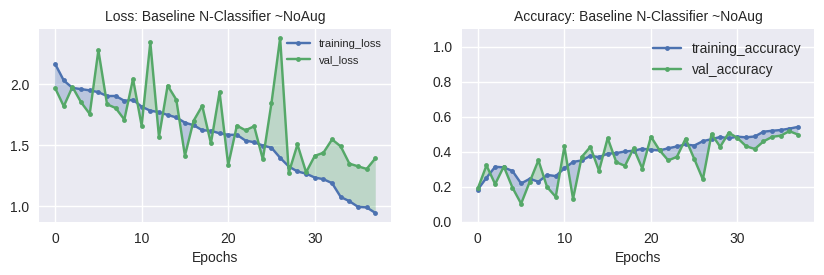

In [ ]:
plot_training_curves(history_SL_noaug, 'Baseline N-Classifier ~NoAug')

## Experiment 2: Supervised contrastive learning


In [ ]:
encoder = create_encoder()
encoder_with_projection_head = add_projection_head(encoder)
encoder_with_projection_head.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=SupervisedContrastiveLoss(temperature),
)
history_SCL_encoder_noaug = encoder_with_projection_head.fit(
    train_ds_v, batch_size=batch_size, epochs=num_epochs
)

Epoch 1/100
634/634 [==============================] - 685s 1s/step - loss: 3.3612
Epoch 2/100
634/634 [==============================] - 51s 79ms/step - loss: 3.3055
Epoch 3/100
634/634 [==============================] - 50s 77ms/step - loss: 3.2795
Epoch 4/100
634/634 [==============================] - 50s 77ms/step - loss: 3.2703
Epoch 5/100
634/634 [==============================] - 50s 77ms/step - loss: 3.2537
Epoch 6/100
634/634 [==============================] - 50s 78ms/step - loss: 3.2349
Epoch 7/100
634/634 [==============================] - 50s 78ms/step - loss: 3.2265
Epoch 8/100
634/634 [==============================] - 50s 78ms/step - loss: 3.2095
Epoch 9/100
634/634 [==============================] - 50s 78ms/step - loss: 3.1955
Epoch 10/100
634/634 [==============================] - 50s 78ms/step - loss: 3.1947
Epoch 11/100
634/634 [==============================] - 50s 78ms/step - loss: 3.1807
Epoch 12/100
634/634 [==============================] - 50s 78ms/step - los

In [ ]:
classifier = create_classifier(encoder_with_projection_head, trainable=False)
history_SCL_noaug = run_experiment(train_ds_v, val_ds_v, classifier)

Epoch 1/100
634/634 [==============================] - 214s 327ms/step - loss: 2.2102 - accuracy: 0.7646 - AUC: 0.8511 - Precision: 0.3413 - Recall: 0.9181 - F1 score: 0.5069 - val_loss: 2.7414 - val_accuracy: 0.5987 - val_AUC: 0.7680 - val_Precision: 0.2928 - val_Recall: 0.6996 - val_F1 score: 0.3340 - lr: 0.0010
Epoch 2/100
634/634 [==============================] - 63s 98ms/step - loss: 1.2914 - accuracy: 0.8331 - AUC: 0.8879 - Precision: 0.3900 - Recall: 0.9471 - F1 score: 0.6049 - val_loss: 2.0343 - val_accuracy: 0.6024 - val_AUC: 0.7867 - val_Precision: 0.3043 - val_Recall: 0.7327 - val_F1 score: 0.3463 - lr: 0.0010
Epoch 3/100
634/634 [==============================] - 62s 96ms/step - loss: 1.0761 - accuracy: 0.8535 - AUC: 0.9060 - Precision: 0.4292 - Recall: 0.9515 - F1 score: 0.6313 - val_loss: 1.9404 - val_accuracy: 0.5748 - val_AUC: 0.8097 - val_Precision: 0.4029 - val_Recall: 0.6581 - val_F1 score: 0.3272 - lr: 0.0010
Epoch 4/100
634/634 [==============================] - 6

<ipython-input-3-ba513de2f957>:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn') #ggplot #bmh


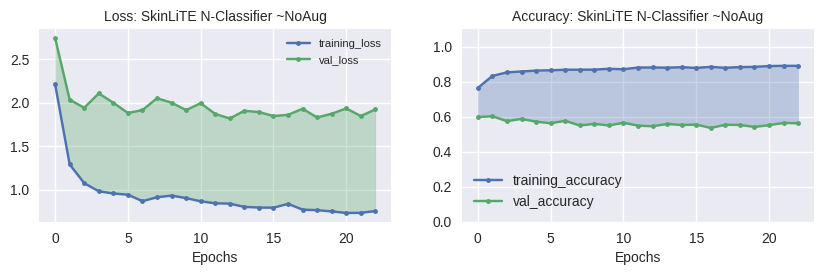

In [ ]:
plot_training_curves(history_SCL_noaug, 'SkinLiTE N-Classifier ~NoAug')



---



# 🟣 RandAug


## Experiment 1: Baseline Classifier


In [ ]:
encoder = create_encoder()
classifier = create_classifier(encoder)
history_SL_randaug = run_experiment(randaug_ds, val_ds_v, classifier)

Epoch 1/100
634/634 [==============================] - 1993s 733ms/step - loss: 2.2914 - accuracy: 0.1174 - AUC: 0.5179 - Precision: 0.1278 - Recall: 0.1044 - F1 score: 0.0821 - val_loss: 2.0893 - val_accuracy: 0.0197 - val_AUC: 0.4020 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1 score: 0.0164 - lr: 0.0010
Epoch 2/100
634/634 [==============================] - 162s 182ms/step - loss: 2.0898 - accuracy: 0.0665 - AUC: 0.4562 - Precision: 0.1073 - Recall: 0.0103 - F1 score: 0.0482 - val_loss: 2.0969 - val_accuracy: 0.0079 - val_AUC: 0.3779 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1 score: 0.0035 - lr: 0.0010
Epoch 3/100
634/634 [==============================] - 163s 184ms/step - loss: 2.0907 - accuracy: 0.0911 - AUC: 0.4742 - Precision: 0.2435 - Recall: 0.0037 - F1 score: 0.0613 - val_loss: 2.0363 - val_accuracy: 0.4848 - val_AUC: 0.7258 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1 score: 0.1237 - lr: 0.0010
Epoch 4/100
634/634 [======

<ipython-input-3-ba513de2f957>:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn') #ggplot #bmh


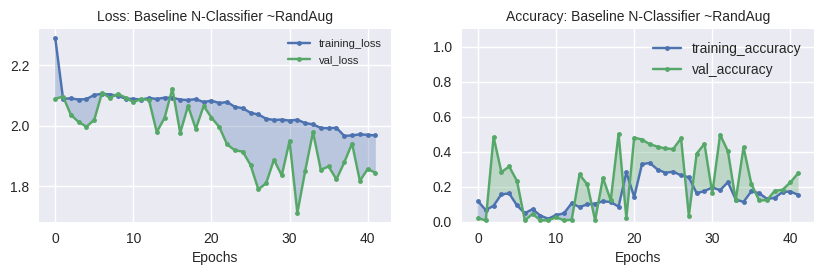

In [ ]:
plot_training_curves(history_SL_randaug, 'Baseline N-Classifier ~RandAug')

## Experiment 2: Supervised contrastive learning


In [ ]:
encoder = create_encoder()
encoder_with_projection_head = add_projection_head(encoder)
encoder_with_projection_head.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=SupervisedContrastiveLoss(temperature),
)
history_SCL_encoder_randaug = encoder_with_projection_head.fit(
    randaug_ds, batch_size=batch_size, epochs=num_epochs
)

Epoch 1/100
634/634 [==============================] - 169s 154ms/step - loss: 3.4182
Epoch 2/100
634/634 [==============================] - 145s 155ms/step - loss: 3.3975
Epoch 3/100
634/634 [==============================] - 144s 155ms/step - loss: 3.3940
Epoch 4/100
634/634 [==============================] - 146s 157ms/step - loss: 3.3897
Epoch 5/100
634/634 [==============================] - 145s 157ms/step - loss: 3.3827
Epoch 6/100
634/634 [==============================] - 144s 155ms/step - loss: 3.3796
Epoch 7/100
634/634 [==============================] - 145s 156ms/step - loss: 3.3804
Epoch 8/100
634/634 [==============================] - 144s 155ms/step - loss: 3.3774
Epoch 9/100
634/634 [==============================] - 144s 155ms/step - loss: 3.3742
Epoch 10/100
634/634 [==============================] - 145s 156ms/step - loss: 3.3726
Epoch 11/100
634/634 [==============================] - 145s 155ms/step - loss: 3.3664
Epoch 12/100
634/634 [==============================

In [ ]:
classifier = create_classifier(encoder_with_projection_head, trainable=False)
history_SCL_randaug = run_experiment(randaug_ds, val_ds_v, classifier)

Epoch 1/100
634/634 [==============================] - 153s 163ms/step - loss: 10.3666 - accuracy: 0.1804 - AUC: 0.5627 - Precision: 0.1546 - Recall: 0.5270 - F1 score: 0.1195 - val_loss: 2.2521 - val_accuracy: 0.0184 - val_AUC: 0.3764 - val_Precision: 0.0075 - val_Recall: 0.0038 - val_F1 score: 0.0144 - lr: 0.0010
Epoch 2/100
634/634 [==============================] - 149s 163ms/step - loss: 2.7211 - accuracy: 0.1644 - AUC: 0.5575 - Precision: 0.1612 - Recall: 0.3320 - F1 score: 0.1105 - val_loss: 2.1098 - val_accuracy: 0.0079 - val_AUC: 0.3672 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1 score: 0.0020 - lr: 0.0010
Epoch 3/100
634/634 [==============================] - 149s 163ms/step - loss: 2.2330 - accuracy: 0.1372 - AUC: 0.5291 - Precision: 0.1679 - Recall: 0.1748 - F1 score: 0.0970 - val_loss: 2.1031 - val_accuracy: 0.0087 - val_AUC: 0.3851 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1 score: 0.0053 - lr: 0.0010
Epoch 4/100
634/634 [==============

<ipython-input-3-ba513de2f957>:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn') #ggplot #bmh


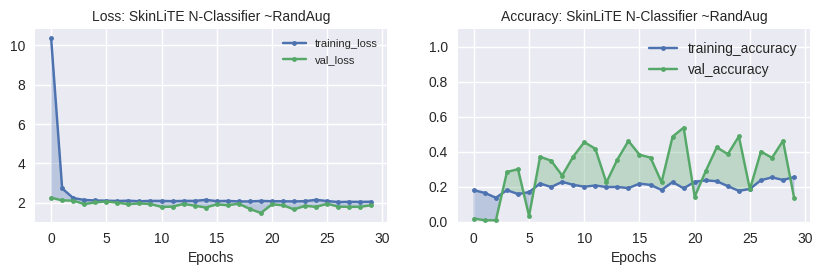

In [ ]:
plot_training_curves(history_SCL_randaug, 'SkinLiTE N-Classifier ~RandAug')



---



# 🟣 AugMix


## Experiment 1: Baseline Classifier


In [ ]:
encoder = create_encoder()
classifier = create_classifier(encoder)
history_SL_augmix = run_experiment(augmix_ds, val_ds_v, classifier)

Epoch 1/100
634/634 [==============================] - 638s 923ms/step - loss: 2.1961 - accuracy: 0.1486 - AUC: 0.5330 - Precision: 0.1855 - Recall: 0.1277 - F1 score: 0.1023 - val_loss: 2.0225 - val_accuracy: 0.1238 - val_AUC: 0.4776 - val_Precision: 0.3538 - val_Recall: 0.0989 - val_F1 score: 0.0709 - lr: 0.0010
Epoch 2/100
634/634 [==============================] - 628s 918ms/step - loss: 2.0451 - accuracy: 0.1983 - AUC: 0.5792 - Precision: 0.2894 - Recall: 0.1605 - F1 score: 0.1125 - val_loss: 1.9396 - val_accuracy: 0.2523 - val_AUC: 0.6379 - val_Precision: 0.3396 - val_Recall: 0.1498 - val_F1 score: 0.1036 - lr: 0.0010
Epoch 3/100
634/634 [==============================] - 626s 916ms/step - loss: 2.0502 - accuracy: 0.2411 - AUC: 0.5921 - Precision: 0.2903 - Recall: 0.1736 - F1 score: 0.1273 - val_loss: 2.2543 - val_accuracy: 0.3247 - val_AUC: 0.7009 - val_Precision: 0.2664 - val_Recall: 0.6244 - val_F1 score: 0.0777 - lr: 0.0010
Epoch 4/100
634/634 [==============================]

<ipython-input-9-ba513de2f957>:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn') #ggplot #bmh


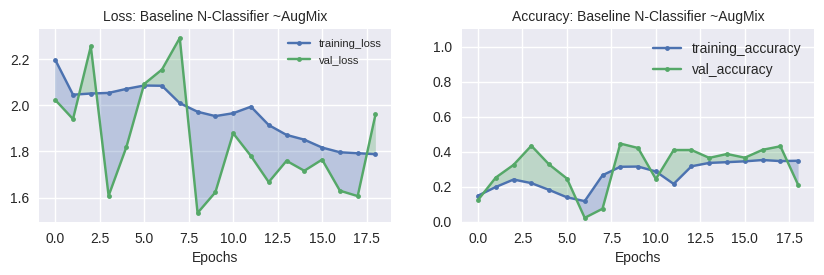

In [ ]:
plot_training_curves(history_SL_augmix, 'Baseline N-Classifier ~AugMix')

## Experiment 2: Supervised contrastive learning


In [ ]:
encoder = create_encoder()
encoder_with_projection_head = add_projection_head(encoder)
encoder_with_projection_head.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=SupervisedContrastiveLoss(temperature),
)
history_SCL_encoder_augmix = encoder_with_projection_head.fit(
    augmix_ds, batch_size=batch_size, epochs=num_epochs
)

Epoch 1/100
634/634 [==============================] - 2472s 893ms/step - loss: 3.3963
Epoch 2/100
634/634 [==============================] - 612s 892ms/step - loss: 3.3622
Epoch 3/100
634/634 [==============================] - 612s 894ms/step - loss: 3.3324
Epoch 4/100
634/634 [==============================] - 612s 893ms/step - loss: 3.3186
Epoch 5/100
634/634 [==============================] - 611s 891ms/step - loss: 3.3129
Epoch 6/100
634/634 [==============================] - 610s 890ms/step - loss: 3.3016
Epoch 7/100
634/634 [==============================] - 611s 892ms/step - loss: 3.2899
Epoch 8/100
634/634 [==============================] - 613s 894ms/step - loss: 3.2844
Epoch 9/100
634/634 [==============================] - 615s 898ms/step - loss: 3.2804
Epoch 10/100
634/634 [==============================] - 611s 892ms/step - loss: 3.2730
Epoch 11/100
634/634 [==============================] - 612s 892ms/step - loss: 3.2677
Epoch 12/100
634/634 [=============================

In [ ]:
classifier = create_classifier(encoder_with_projection_head, trainable=False)
history_SCL_augmix = run_experiment(augmix_ds, val_ds_v, classifier)

Epoch 1/100
634/634 [==============================] - 948s 1s/step - loss: 4.8439 - accuracy: 0.4354 - AUC: 0.7068 - Precision: 0.2156 - Recall: 0.7962 - F1 score: 0.2594 - val_loss: 1.5661 - val_accuracy: 0.5792 - val_AUC: 0.7827 - val_Precision: 0.5458 - val_Recall: 0.3798 - val_F1 score: 0.3422 - lr: 0.0010
Epoch 2/100
634/634 [==============================] - 619s 904ms/step - loss: 1.8837 - accuracy: 0.5077 - AUC: 0.7580 - Precision: 0.2516 - Recall: 0.7614 - F1 score: 0.3050 - val_loss: 1.5895 - val_accuracy: 0.5734 - val_AUC: 0.7909 - val_Precision: 0.5376 - val_Recall: 0.3277 - val_F1 score: 0.3777 - lr: 0.0010
Epoch 3/100
634/634 [==============================] - 617s 901ms/step - loss: 1.7108 - accuracy: 0.5412 - AUC: 0.7728 - Precision: 0.2703 - Recall: 0.7422 - F1 score: 0.3295 - val_loss: 1.5066 - val_accuracy: 0.5614 - val_AUC: 0.8003 - val_Precision: 0.3894 - val_Recall: 0.5523 - val_F1 score: 0.3269 - lr: 0.0010
Epoch 4/100
634/634 [==============================] - 

<ipython-input-4-ba513de2f957>:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn') #ggplot #bmh


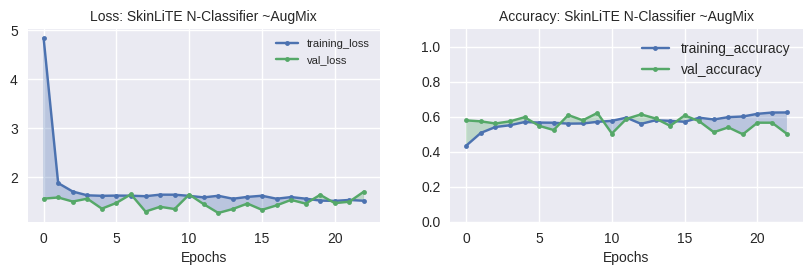

In [ ]:
plot_training_curves(history_SCL_augmix, 'SkinLiTE N-Classifier ~AugMix')

# 🟣 MixUp


## Experiment 1: Baseline Classifier


In [ ]:
encoder = create_encoder()
classifier = create_classifier(encoder)
history_SL_mixup = run_experiment(mixup_ds, val_ds_v, classifier)

Epoch 1/100
634/634 [==============================] - 1315s 371ms/step - loss: 2.1367 - accuracy: 0.2522 - AUC: 0.6301 - Precision: 0.3831 - Recall: 0.1427 - F1 score: 0.1304 - val_loss: 2.1569 - val_accuracy: 0.1727 - val_AUC: 0.6555 - val_Precision: 0.2775 - val_Recall: 0.0687 - val_F1 score: 0.0570 - lr: 0.0010
Epoch 2/100
634/634 [==============================] - 98s 81ms/step - loss: 2.0534 - accuracy: 0.3402 - AUC: 0.6489 - Precision: 0.4477 - Recall: 0.1705 - F1 score: 0.1382 - val_loss: 1.9839 - val_accuracy: 0.2438 - val_AUC: 0.5960 - val_Precision: 0.4986 - val_Recall: 0.0691 - val_F1 score: 0.1164 - lr: 0.0010
Epoch 3/100
634/634 [==============================] - 98s 81ms/step - loss: 2.0231 - accuracy: 0.3178 - AUC: 0.6340 - Precision: 0.4965 - Recall: 0.1775 - F1 score: 0.1451 - val_loss: 1.8839 - val_accuracy: 0.4680 - val_AUC: 0.7488 - val_Precision: 0.4369 - val_Recall: 0.1749 - val_F1 score: 0.1477 - lr: 0.0010
Epoch 4/100
634/634 [==============================] - 

<ipython-input-4-ba513de2f957>:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn') #ggplot #bmh


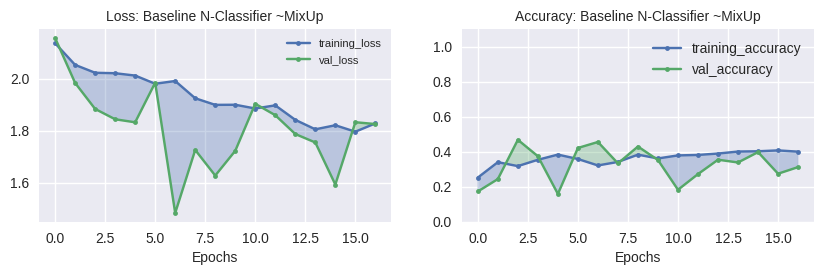

In [ ]:
plot_training_curves(history_SL_mixup, 'Baseline N-Classifier ~MixUp')

## Experiment 2: Supervised contrastive learning


In [ ]:
encoder = create_encoder()
encoder_with_projection_head = add_projection_head(encoder)
encoder_with_projection_head.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=SupervisedContrastiveLoss(temperature),
)
history_SCL_encoder_mixup = encoder_with_projection_head.fit(
    mixup_ds, batch_size=batch_size, epochs=num_epochs
)

Epoch 1/100
634/634 [==============================] - 110s 60ms/step - loss: 3.3611
Epoch 2/100
634/634 [==============================] - 84s 61ms/step - loss: 3.3104
Epoch 3/100
634/634 [==============================] - 84s 61ms/step - loss: 3.2909
Epoch 4/100
634/634 [==============================] - 84s 61ms/step - loss: 3.2745
Epoch 5/100
634/634 [==============================] - 84s 61ms/step - loss: 3.2627
Epoch 6/100
634/634 [==============================] - 84s 61ms/step - loss: 3.2554
Epoch 7/100
634/634 [==============================] - 84s 61ms/step - loss: 3.2416
Epoch 8/100
634/634 [==============================] - 84s 61ms/step - loss: 3.2348
Epoch 9/100
634/634 [==============================] - 84s 61ms/step - loss: 3.2192
Epoch 10/100
634/634 [==============================] - 84s 61ms/step - loss: 3.2111
Epoch 11/100
634/634 [==============================] - 85s 61ms/step - loss: 3.2044
Epoch 12/100
634/634 [==============================] - 85s 61ms/step - l

In [ ]:
classifier = create_classifier(encoder_with_projection_head, trainable=False)
history_SCL_mixup = run_experiment(mixup_ds, val_ds_v, classifier)

Epoch 1/100
634/634 [==============================] - 84s 54ms/step - loss: 2.8133 - accuracy: 0.6525 - AUC: 0.7045 - Precision: 0.3652 - Recall: 0.6834 - F1 score: 0.3748 - val_loss: 1.3671 - val_accuracy: 0.5574 - val_AUC: 0.7218 - val_Precision: 0.2205 - val_Recall: 0.6773 - val_F1 score: 0.3670 - lr: 0.0010
Epoch 2/100
634/634 [==============================] - 78s 50ms/step - loss: 1.5190 - accuracy: 0.7289 - AUC: 0.7298 - Precision: 0.3913 - Recall: 0.6738 - F1 score: 0.4461 - val_loss: 1.5945 - val_accuracy: 0.4846 - val_AUC: 0.6832 - val_Precision: 0.2676 - val_Recall: 0.4720 - val_F1 score: 0.3379 - lr: 0.0010
Epoch 3/100
634/634 [==============================] - 78s 50ms/step - loss: 1.3983 - accuracy: 0.7542 - AUC: 0.7357 - Precision: 0.3959 - Recall: 0.6732 - F1 score: 0.4747 - val_loss: 1.3785 - val_accuracy: 0.5497 - val_AUC: 0.7773 - val_Precision: 0.3297 - val_Recall: 0.6196 - val_F1 score: 0.3670 - lr: 0.0010
Epoch 4/100
634/634 [==============================] - 78s

<ipython-input-4-ba513de2f957>:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn') #ggplot #bmh


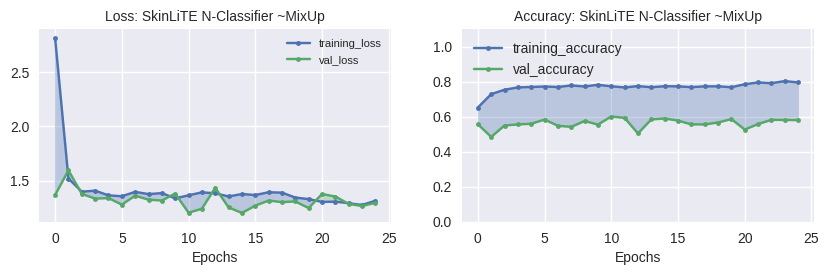

In [ ]:
plot_training_curves(history_SCL_mixup, 'SkinLiTE N-Classifier ~MixUp')

# 🟣 CutMix


## Experiment 1: Baseline Classifier


In [ ]:
encoder = create_encoder()
classifier = create_classifier(encoder)
history_SL_cutmix = run_experiment(cutmix_ds, val_ds_v, classifier)

Epoch 1/100
634/634 [==============================] - 1969s 635ms/step - loss: 2.1191 - accuracy: 0.4316 - AUC: 0.7224 - Precision: 0.5667 - Recall: 0.2253 - F1 score: 0.1223 - val_loss: 1.7973 - val_accuracy: 0.5120 - val_AUC: 0.8178 - val_Precision: 0.8064 - val_Recall: 0.1948 - val_F1 score: 0.0973 - lr: 0.0010
Epoch 2/100
634/634 [==============================] - 96s 79ms/step - loss: 2.0651 - accuracy: 0.4689 - AUC: 0.7394 - Precision: 0.6561 - Recall: 0.2326 - F1 score: 0.1210 - val_loss: 1.7980 - val_accuracy: 0.5036 - val_AUC: 0.7902 - val_Precision: 0.4343 - val_Recall: 0.2923 - val_F1 score: 0.1157 - lr: 0.0010
Epoch 3/100
634/634 [==============================] - 96s 79ms/step - loss: 2.0042 - accuracy: 0.4881 - AUC: 0.7469 - Precision: 0.6905 - Recall: 0.2574 - F1 score: 0.1145 - val_loss: 1.6278 - val_accuracy: 0.5077 - val_AUC: 0.7906 - val_Precision: 0.4968 - val_Recall: 0.5330 - val_F1 score: 0.0842 - lr: 0.0010
Epoch 4/100
634/634 [==============================] - 

<ipython-input-3-ba513de2f957>:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn') #ggplot #bmh


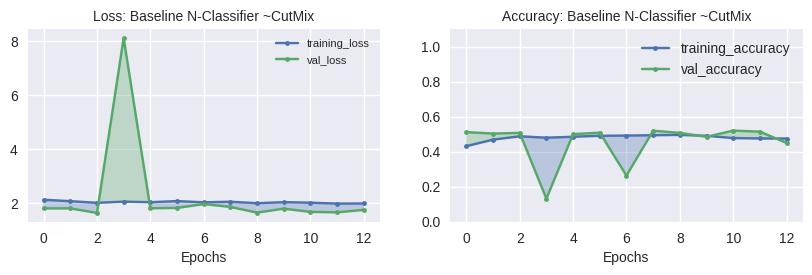

In [ ]:
plot_training_curves(history_SL_cutmix, 'Baseline N-Classifier ~CutMix')

## Experiment 2: Supervised contrastive learning


In [ ]:
encoder = create_encoder()
encoder_with_projection_head = add_projection_head(encoder)
encoder_with_projection_head.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=SupervisedContrastiveLoss(temperature),
)
history_SCL_encoder_cutmix = encoder_with_projection_head.fit(
    cutmix_ds, batch_size=batch_size, epochs=num_epochs
)

Epoch 1/100
634/634 [==============================] - 109s 60ms/step - loss: 3.3960
Epoch 2/100
634/634 [==============================] - 84s 60ms/step - loss: 3.3635
Epoch 3/100
634/634 [==============================] - 84s 60ms/step - loss: 3.3526
Epoch 4/100
634/634 [==============================] - 84s 60ms/step - loss: 3.3538
Epoch 5/100
634/634 [==============================] - 84s 60ms/step - loss: 3.3400
Epoch 6/100
634/634 [==============================] - 84s 60ms/step - loss: 3.3295
Epoch 7/100
634/634 [==============================] - 84s 60ms/step - loss: 3.3338
Epoch 8/100
634/634 [==============================] - 84s 60ms/step - loss: 3.3258
Epoch 9/100
634/634 [==============================] - 85s 60ms/step - loss: 3.3206
Epoch 10/100
634/634 [==============================] - 84s 60ms/step - loss: 3.3127
Epoch 11/100
634/634 [==============================] - 84s 60ms/step - loss: 3.3207
Epoch 12/100
634/634 [==============================] - 84s 60ms/step - l

In [ ]:
classifier = create_classifier(encoder_with_projection_head, trainable=False)
history_SCL_cutmix = run_experiment(cutmix_ds, val_ds_v, classifier)

Epoch 1/100
634/634 [==============================] - 100s 79ms/step - loss: 7.6547 - accuracy: 0.2587 - AUC: 0.6219 - Precision: 0.2951 - Recall: 0.5807 - F1 score: 0.1451 - val_loss: 2.0505 - val_accuracy: 0.4961 - val_AUC: 0.7205 - val_Precision: 1.0000 - val_Recall: 3.9479e-04 - val_F1 score: 0.1213 - lr: 0.0010
Epoch 2/100
634/634 [==============================] - 94s 77ms/step - loss: 2.2030 - accuracy: 0.3646 - AUC: 0.6638 - Precision: 0.3512 - Recall: 0.4121 - F1 score: 0.1590 - val_loss: 1.9123 - val_accuracy: 0.5422 - val_AUC: 0.7806 - val_Precision: 0.6765 - val_Recall: 0.0045 - val_F1 score: 0.1803 - lr: 0.0010
Epoch 3/100
634/634 [==============================] - 95s 77ms/step - loss: 1.9975 - accuracy: 0.4471 - AUC: 0.7100 - Precision: 0.4518 - Recall: 0.3400 - F1 score: 0.1667 - val_loss: 1.7417 - val_accuracy: 0.5164 - val_AUC: 0.8279 - val_Precision: 0.8673 - val_Recall: 0.2347 - val_F1 score: 0.1516 - lr: 0.0010
Epoch 4/100
634/634 [==============================] 

<ipython-input-3-ba513de2f957>:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn') #ggplot #bmh


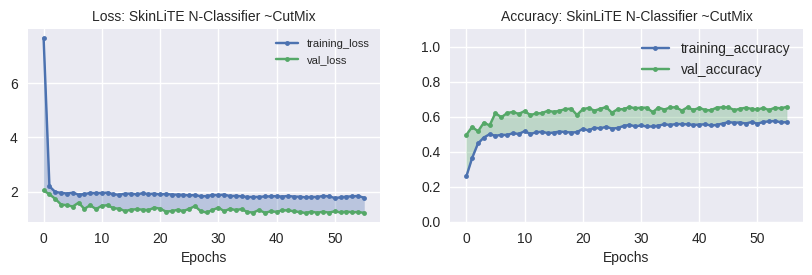

In [ ]:
plot_training_curves(history_SCL_cutmix, 'SkinLiTE N-Classifier ~CutMix')